# Privacy preserving ML with PyTorch

This notebook was developed by IBM Research.

In [1]:
import os

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Random seed
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset from torchvision

In [4]:
# Transforms
transforms_list = [transforms.ToTensor(),
                   transforms.Normalize((0.1307), (0.3081))]

# Create train, val, and test datasets
dataset_path = './datasets'
download = ~os.path.exists(dataset_path)
train = datasets.MNIST(root=os.path.join(dataset_path), train=True, download=download,
                       transform=transforms.Compose(transforms_list))
test = datasets.MNIST(root=os.path.join(dataset_path), train=False,
                      transform=transforms.Compose(transforms_list))

# Create dataloaders
batch_size = 32
num_workers = 0
train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

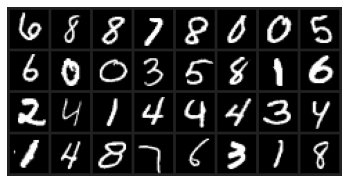

In [5]:
# The prerequisite grid print out
def imshow(img):
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

## Create ConvNet that will be trained on dataset

Architecture exaxmple taken from:
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

In [6]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x        

## Define regular train and test loops

Basic train and test methods taken from:
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

In [67]:
%matplotlib notebook
# Helper function to create dynamic plots
def pltsin(fig, ax, data_len, epoch, step, steps, losses):
    ax.set_title(f'Train Epoch: {epoch} [{step:,d} / {data_len:,d} ({100.*step/data_len:.0f}%)]' + \
                      f'\nLoss: {losses[-1]:.6f}')
    ax.plot(steps, losses, color='red')
    fig.canvas.draw()

In [68]:
def train(epoch, model, optimizer, dataloader, fig=None, ax=None, steps=None, losses=None):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            if fig:
                losses.append(loss.item())
                steps.append(batch_idx + epoch*len(dataloader.dataset)/len(data))
                pltsin(fig, ax, len(dataloader.dataset), epoch, batch_idx * len(data), steps, losses)
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(dataloader.dataset),
#                 100. * batch_idx / len(dataloader), loss.item()))

    return steps, losses
            
def test(model, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
#     accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        accuracy))

<IPython.core.display.Javascript object>


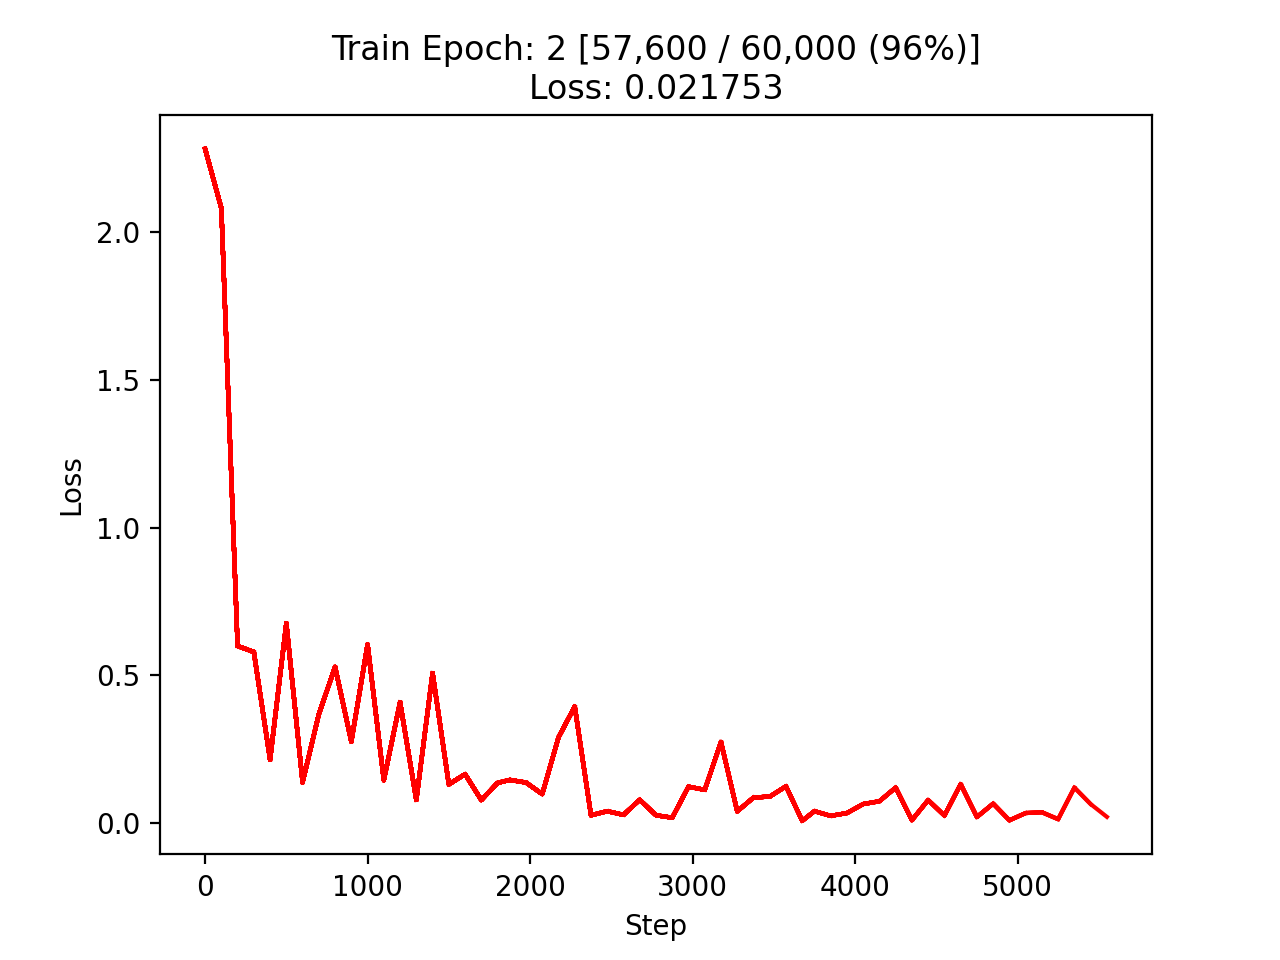


Test set: Average loss: 0.1303, Accuracy: 9582/10000 (96%)


Test set: Average loss: 0.0974, Accuracy: 9701/10000 (97%)


Test set: Average loss: 0.0671, Accuracy: 9776/10000 (98%)



In [71]:
model_cnn = CNN(input_size=28*28, n_feature=6, output_size=10)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
steps, losses = [], []
for epoch in range(0, 3):
    steps, losses = train(epoch, model_cnn, optimizer, train_dataloader,
                          fig=fig, ax=ax, steps=steps, losses=losses)
    test(model_cnn, test_dataloader)

## Define DP trainining

In [ ]:
def train_dp(epoch, model, optimizer, dataloader, noise, grad_clip):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        
        # Now that we have the gradients calculated we need clip gradients and add noise
        grad_norm = 0
        for p in model.parameters():
            param_norm = p.grad.detach().data.norm(2)
            grad_norm += param_norm.item() ** 2
            grad_norm = grad_norm ** 0.5
        for param in model.params():
            param_norm = p.grad.data.norm(2)
            p.grad *= min(1, grad_clip/grad_norm)
            p.grad +=

        optimizer.step()
        if batch_idx % 100 == 0:
            print('DP Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))